<a href="https://colab.research.google.com/github/srirams1983/deep-learning/blob/master/image-classification/Copy_of_dlnd_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [ ]:
import os
import urllib.request
if not isfile('cifar-10-python.tar.gz'):
        with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-100 Dataset') as pbar:
            urlretrieve(
                'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                'cifar-10-python.tar.gz',
                pbar.hook)
cifar10_dataset_folder_path1 = '/content/sample_data/cifar-10-batches'
if not isdir(cifar10_dataset_folder_path1):
        with tarfile.open('/content/cifar-10-python.tar.gz') as tar:
            tar.extractall(path=cifar10_dataset_folder_path1)
            tar.close()


In [ ]:


import tarfile
import pickle
import random
import os
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

cifar10_dataset_folder_path = '/content/sample_data/cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

"""
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""

def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        display(file)
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))

    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))

def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))

    for idx, val in enumerate(x):
        encoded[idx][val] = 1

    return encoded

def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))

def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)

        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation],
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')

def conv_net(x, keep_prob):
    conv1_filter = tf.Variable(tf.random.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.random.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.random.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.random.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))

    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.compat.v1.layers.batch_normalization(conv1_pool)

    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv2_bn = tf.compat.v1.layers.batch_normalization(conv2_pool)

    # 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv3_bn = tf.compat.v1.layers.batch_normalization(conv3_pool)

    # 7, 8
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.compat.v1.layers.batch_normalization(conv4_pool)

    # 9
    flat = tf.compat.v1.layers.flatten(conv4_bn)

    # 10
    full1 = tf.compat.v1.layers.dense(inputs=flat, units=128, activation=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.compat.v1.layers.batch_normalization(full1)

    # 11
    full2 = tf.compat.v1.layers.dense(inputs=full1, units=256, activation=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.compat.v1.layers.batch_normalization(full2)

    # 12
    full3 = tf.compat.v1.layers.dense(inputs=full2, units=512, activation=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.compat.v1.layers.batch_normalization(full3)

    # 13
    full4 = tf.compat.v1.layers.dense(inputs=full3, units=1024, activation=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.compat.v1.layers.batch_normalization(full4)

    # 14
    out = tf.compat.v1.layers.dense(inputs=full3, units=10, activation=None)
    return out



def main():
    
    # Download the dataset (if not exist yet)
    import os
    import urllib.request
    import glob, os

    def del_folder(dir_name):
    
      dir_path = os.getcwd() +  "/{}".format(dir_name)
      display(dir_path)
      try:
          os.rmdir(dir_path)  # remove the folder
      except:
          print("OSError")   # couldn't remove the folder because we have files inside it
      finally:
          # now iterate through files in that folder and delete them one by one and delete the folder at the end
          try:
              for filepath in os.listdir(dir_path):
                  os.remove(dir_path +  "/{}".format(filepath))
              os.rmdir(dir_path)
              print("folder is deleted")
          except:

              print("folder is not there")

    
    if not isfile('cifar-10-python.tar.gz'):
        with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-100 Dataset') as pbar:
            urlretrieve(
                'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                'cifar-10-python.tar.gz',
                pbar.hook)
    cifar10_dataset_folder_path = '/content/cifar-10-batches-py'

    if isdir(cifar10_dataset_folder_path):
       del_folder(cifar10_dataset_folder_path)
    if not isdir(cifar10_dataset_folder_path):
        with tarfile.open('/content/cifar-10-python.tar.gz') as tar:
            tar.extractall()
            tar.close()

    if not os.path.isdir("/content/image_classification"):
      os.mkdir('/content/image_classification')
    if not os.path.isdir('/content/save_model'):
      os.mkdir('/content/save_model')

    # Explore the dataset
    batch_id = 3
    sample_id = 7000

    display(cifar10_dataset_folder_path)

    display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

    # Preprocess all the data and save it
    preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

    # load the saved dataset
    valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

    # Hyper parameters
    epochs = 10
    batch_size = 128
    keep_probability = 0.7
    learning_rate = 0.001
    best_eval_acc = 0

    # Remove previous weights, bias, inputs, etc..
    tf.compat.v1.reset_default_graph()

    # Inputs
    x = tf.compat.v1.placeholder(tf.float32, shape=(None, 32, 32, 3), name='x')
    y =  tf.compat.v1.placeholder(tf.float32, shape=(None, 10), name='y')
    keep_prob = tf.compat.v1.placeholder(tf.float32, name='keep_prob')

    # Build model
    logits = conv_net(x, keep_prob)
    model = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training

    # Loss and Optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    saver = tf.train.Saver() # will keep last 5 epochs
    best_saver = tf.train.Saver(max_to_keep=1)  # only keep 1 best checkpoint (best on eval)
    restore_from = None
    # Training Phase
    save_model_path = './image_classification'
    model_dir = './save_model'

    print('Training...')
    with tf.compat.v1.Session() as sess:
        # Initializing the variables
        sess.run(tf.compat.v1.global_variables_initializer())
        if restore_from is not None:
            logging.info("Restoring parameters from {}".format(restore_from))
            if os.path.isdir(restore_from):
                restore_from = tf.train.latest_checkpoint(restore_from)
                begin_at_epoch = int(restore_from.split('-')[-1])
            saver.restore(sess, restore_from)

        # Training cycle
        for epoch in range(epochs):
            # Loop over all batches
            n_batches = 5
            for batch_i in range(1, n_batches + 1):
                for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                    #train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                    sess.run(optimizer,
                          feed_dict={
                          x: batch_features,
                          y: batch_labels,
                          keep_prob: 0.7
                    })
                print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
                loss = sess.run(cost,
                    feed_dict={
                        x: batch_features,
                        y: batch_labels,
                        keep_prob: 1.
                    })
                valid_acc = sess.run(accuracy,
                         feed_dict={
                             x: valid_features,
                             y: valid_labels,
                             keep_prob: 1.
                         })
                print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))
            
            if valid_acc >= best_eval_acc:
              best_eval_acc = valid_acc
              best_save_path = os.path.join(model_dir, 'best_weights', 'after-epoch')
              display(best_save_path)
              best_saver.save(sess, best_save_path, global_step=epoch + 1)
          # Save Model
            save_model_path = os.path.join(model_dir, 'last_weights', 'after-epoch')
            #saver = tf.train.Saver()
            save_path = saver.save(sess, save_model_path,global_step=epoch + 1)

if __name__ == "__main__":
    main()

'/content//content/cifar-10-batches-py'

OSError
folder is not there


'/content/cifar-10-batches-py'

<_io.BufferedReader name='/content/cifar-10-batches-py/data_batch_3'>


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 7000:
Image - Min Value: 24 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


<_io.BufferedReader name='/content/cifar-10-batches-py/data_batch_1'>

<_io.BufferedReader name='/content/cifar-10-batches-py/data_batch_2'>

<_io.BufferedReader name='/content/cifar-10-batches-py/data_batch_3'>

<_io.BufferedReader name='/content/cifar-10-batches-py/data_batch_4'>

<_io.BufferedReader name='/content/cifar-10-batches-py/data_batch_5'>

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/normalization.py:308: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  '`tf.layers.batch_normalization` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:329: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` i

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.1219 Validation Accuracy: 0.251800
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.8855 Validation Accuracy: 0.241600
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.6079 Validation Accuracy: 0.291000
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.6542 Validation Accuracy: 0.365800
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.5715 Validation Accuracy: 0.350400


'./save_model/best_weights/after-epoch'

Epoch  2, CIFAR-10 Batch 1:  Loss:     1.5419 Validation Accuracy: 0.422400
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.3605 Validation Accuracy: 0.422800


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def display_image_predictions(features, labels, predictions, top_n_predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=top_n_predictions, ncols=2, figsize=(20, 10))
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions
   
    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        if (image_i < top_n_predictions):
            pred_names = [label_names[pred_i] for pred_i in pred_indicies]
            correct_name = label_names[label_id]
            
            axies[image_i][0].imshow((feature*255).astype(np.int32, copy=False))
            axies[image_i][0].set_title(correct_name)
            axies[image_i][0].set_axis_off()

            axies[image_i][1].barh(ind + margin, pred_values[:3], width)
            axies[image_i][1].set_yticks(ind + margin)
            axies[image_i][1].set_yticklabels(pred_names[::-1])
            axies[image_i][1].set_xticks([0, 0.5, 1.0])

INFO:tensorflow:Restoring parameters from ./save_model/last_weights/after-epoch-10
Testing Accuracy: 0.7247213375796179



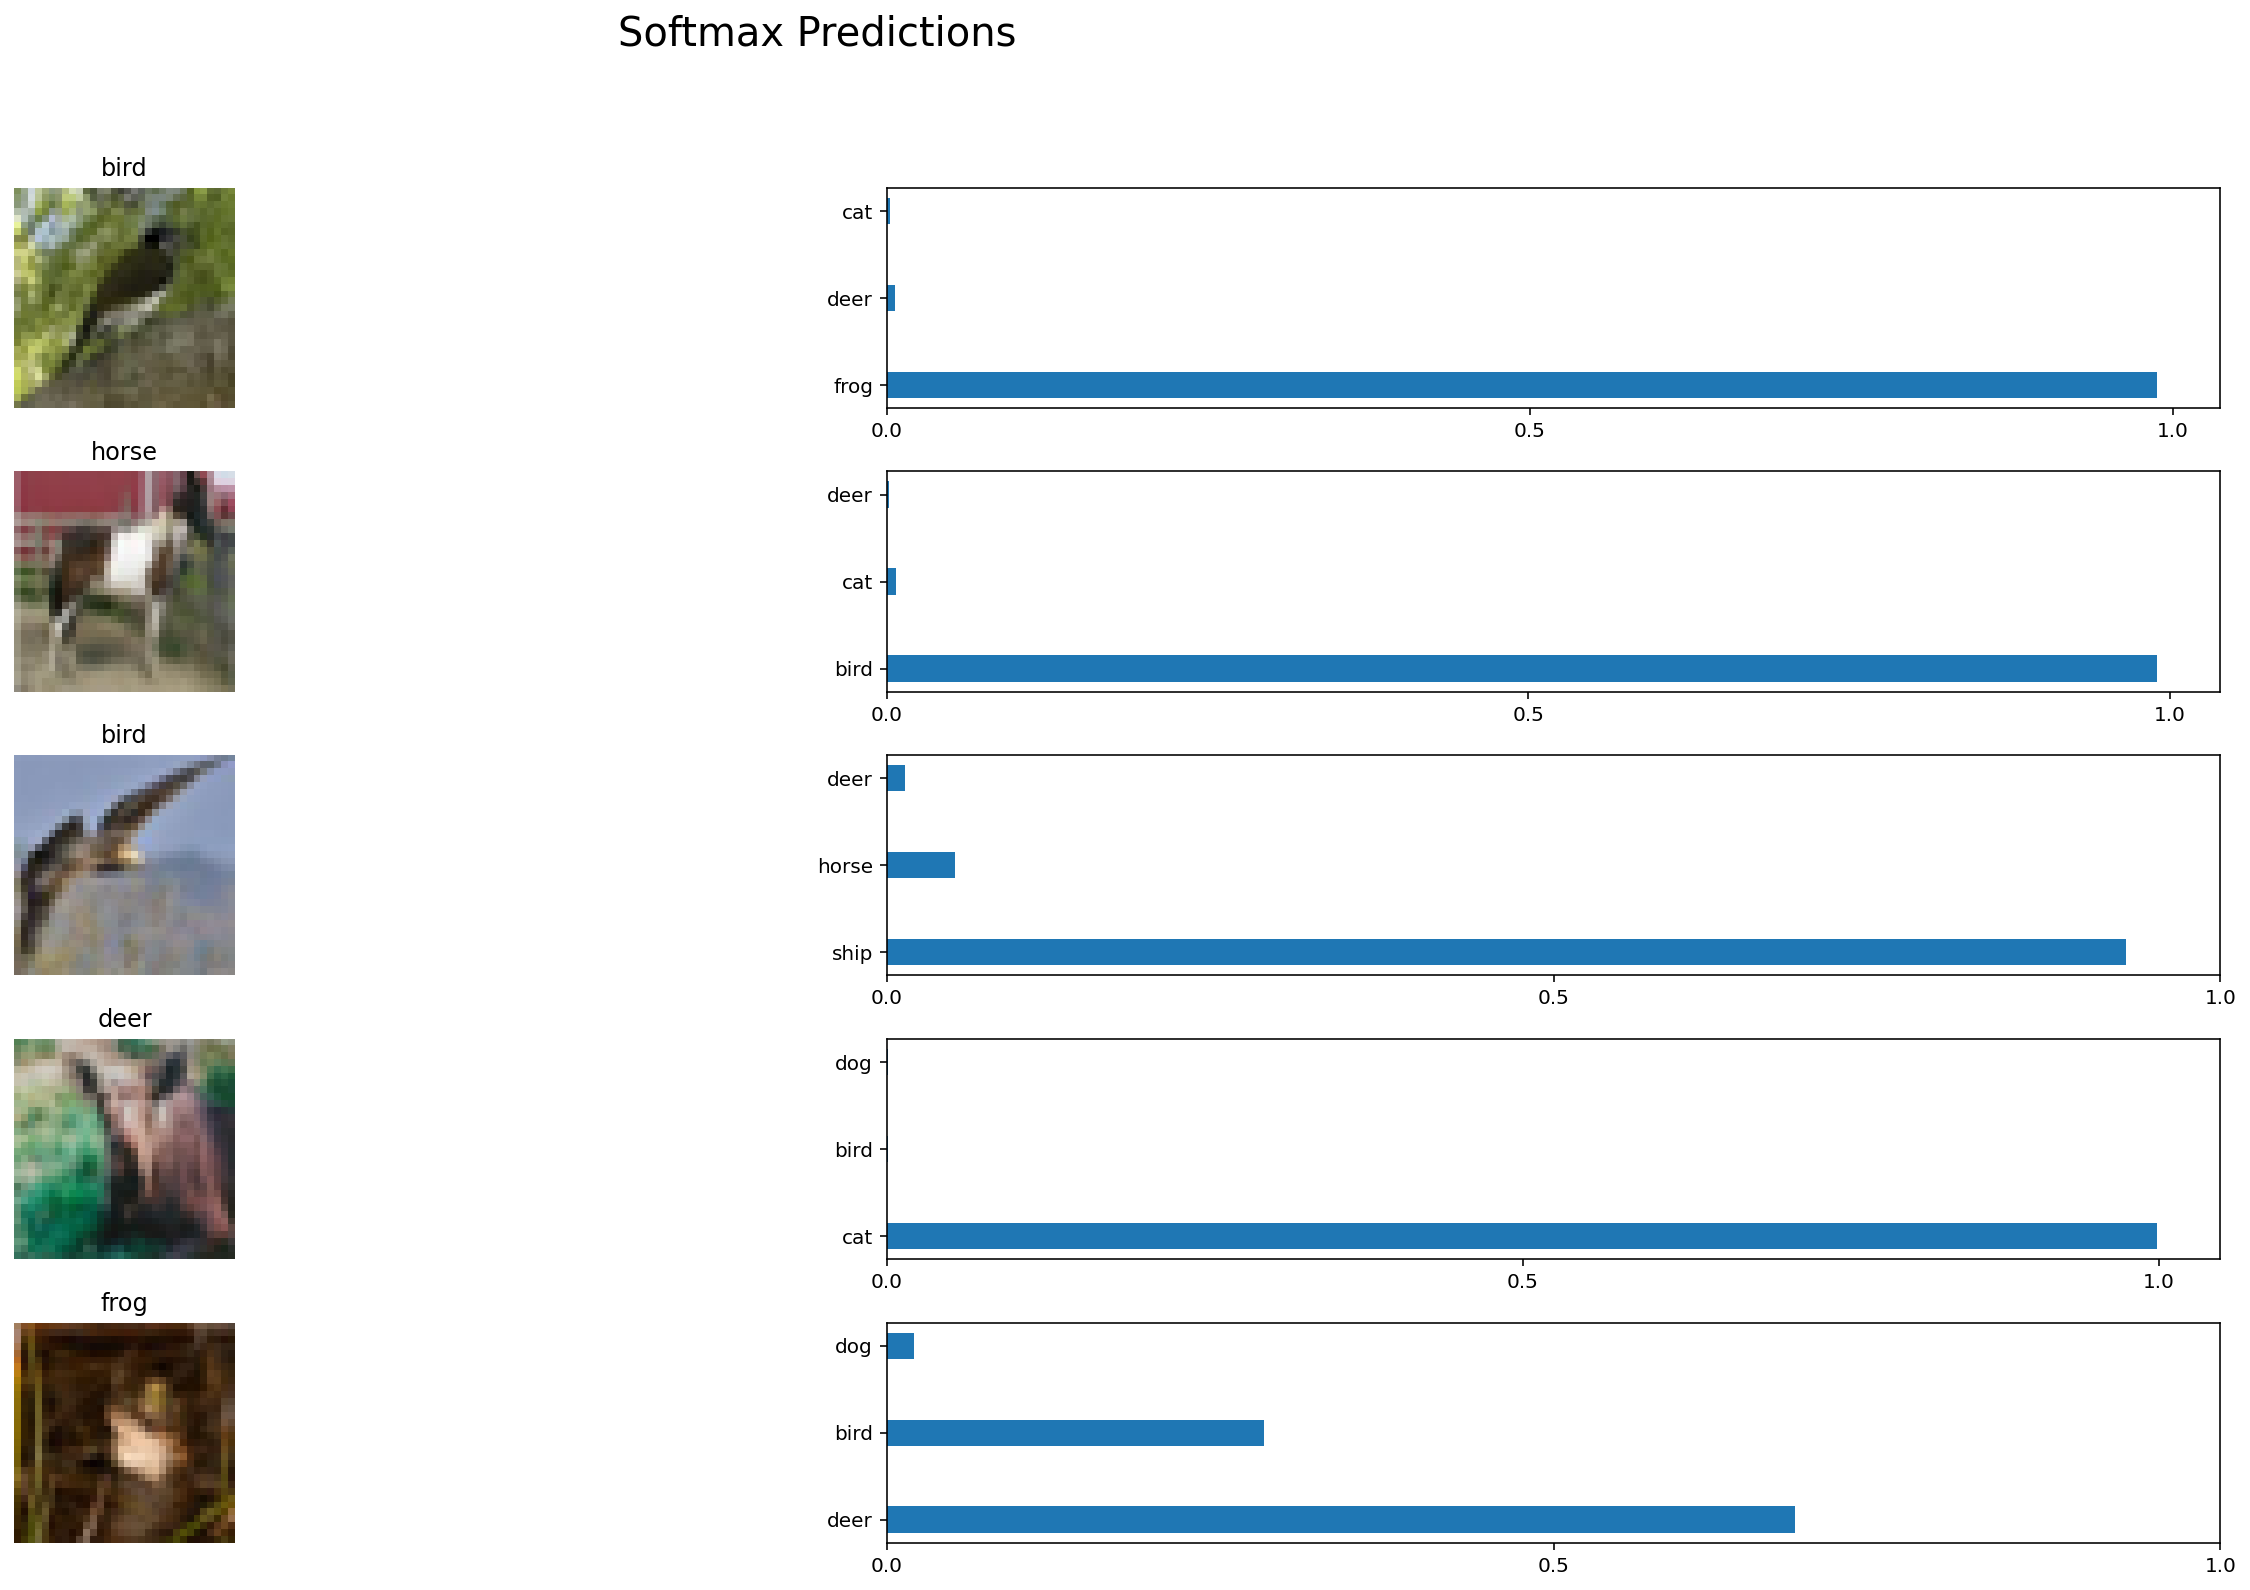

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random
model_dir = './save_model'
save_model_path = os.path.join(model_dir, 'last_weights', 'after-epoch-10')
batch_size = 64
n_samples = 10
top_n_predictions = 5

def test_model():
    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.compat.v1.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.compat.v1.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions, top_n_predictions)


test_model()

## Why 50-80% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. However, you might notice people are getting scores [well above 80%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because we haven't taught you all there is to know about neural networks. We still need to cover a few more techniques.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "dlnd_image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.

In [ ]:
# function that deletes all files and then folder

import glob, os

def del_folder(dir_name):
    
    dir_path = os.getcwd() +  "/{}".format(dir_name)
    display(dir_path)
    try:
        os.rmdir(dir_path)  # remove the folder
    except:
        print("OSError")   # couldn't remove the folder because we have files inside it
    finally:
        # now iterate through files in that folder and delete them one by one and delete the folder at the end
        try:
            for filepath in os.listdir(dir_path):
                os.remove(dir_path +  "/{}".format(filepath))
            os.rmdir(dir_path)
            print("folder is deleted")
        except:

            print("folder is not there")
del_folder('cifar-10-batches-py')

'/content/sample_data/cifar-10-batches-py'

OSError
folder is not there


In [ ]:
dir_path = os.getcwd() +  "/{}".format('cifar-10-batches/cifar-10-batches-py')
display(dir_path)
for file in os.listdir('/content/sample_data/cifar-10-batches/cifar-10-batches-py'):
     display(file)
     os.remove(dir_path +  "/{}".format(file))
%cd '/content/sample_data'
!pwd
!ls


'/content/sample_data/cifar-10-batches/cifar-10-batches-py'

'data_batch_3'

'data_batch_4'

'data_batch_2'

'data_batch_1'

'readme.html'

'test_batch'

'data_batch_5'

'batches.meta'

/content/sample_data
/content/sample_data
anscombe.json		      cifar-10-batches	      mnist_train_small.csv
california_housing_test.csv   cifar-10-python.tar.gz  model.zip
california_housing_train.csv  mnist_test.csv	      README.md


In [ ]:
os.rmdir('/content/sample_data/cifar-10-batches')